In [1]:
import sys
print(sys.path)
sys.path.append("./")
print(sys.path)

['', '/home/apospiech/Programme/anaconda3/lib/python35.zip', '/home/apospiech/Programme/anaconda3/lib/python3.5', '/home/apospiech/Programme/anaconda3/lib/python3.5/plat-linux', '/home/apospiech/Programme/anaconda3/lib/python3.5/lib-dynload', '/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages', '/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/Sphinx-1.4.6-py3.5.egg', '/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/json_delta-2.0-py3.5.egg', '/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/setuptools-27.2.0-py3.5.egg', '/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/thrift-0.9.3-py3.5.egg', '/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/thrift_sasl-0.2.1-py3.5.egg', '/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/IPython/extensions', '/home/apospiech/.ipython']
['', '/home/apospiech/Programme/anaconda3/lib/python35.zip', '/home/apospiech/Programme/anaconda3/lib/python3.5', 

In [2]:
from lib.lin_alg_probability import *

In [ ]:
from math import sqrt

In [12]:
def normal_approximation_to_binomial(n, p):
    mu = p * n
    sigma = sqrt(p * (1 - p) * n)
    return mu, sigma

In [23]:
normal_probability_below = normal_cdf

def normal_probability_above(low, mu=0, sigma=1):
    return 1 - normal_cdf(low, mu, sigma)

def normal_probability_between(low, high, mu=0, sigma=1):
    return normal_cdf(high, mu, sigma) - normal_cdf(low, mu, sigma)

def normal_probability_outside(low, high, mu=0, sigma=1):
    return 1- normal_probability_between(low, high, mu, sigma)

In [10]:
def normal_upper_bound(p, mu=0, sigma=1):
    return inverse_normal_cdf(p, mu, sigma)

def normal_lower_bound(p, mu=0, sigma=1):
    return inverse_normal_cdf(1 - p, mu, sigma)

def normal_two_sided_bounds(p, mu=0, sigma=1):
    tail_p = (1 - p) / 2
    upper_bound = normal_lower_bound(tail_p, mu, sigma)
    lower_bound = normal_upper_bound(tail_p, mu, sigma)
    
    return lower_bound, upper_bound

In [19]:
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)
print(mu_0, sigma_0)

500.0 15.811388300841896


In [20]:
low, high = normal_two_sided_bounds(0.95, mu_0, sigma_0)
print(low, high)

469.01026640487555 530.9897335951244


In [28]:
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)
print(mu_1, sigma_1)
type_2_probability = normal_probability_between(low, high, mu_1, sigma_1)
power = 1 - type_2_probability
print(power)

550.0 15.732132722552274
0.8865480012953671


In [29]:
high = normal_upper_bound(0.95, mu_0, sigma_0)
print(high)

type_2_probability = normal_probability_below(high, mu_1, sigma_1)
power = 1 - type_2_probability
print(power)

526.0073585242053
0.9363794803307173


# p-values

In [30]:
def two_sided_p_value(x, mu=0, sigma=1):
    if x >= mu:
        return 2*normal_probability_above(x, mu, sigma)
    else: 
        return 2*normal_probability_below(x, mu, sigma)

In [33]:
two_sided_p_value(529.5, mu_0, sigma_0)

0.06207721579598857

In [39]:
import random

extreme_value_count = 0
for _ in range(100000):
    num_heads = sum(1 if random.random() < 0.5 else 0 for _ in range(1000))
    if num_heads >= 530 or num_heads <= 470:
        extreme_value_count += 1
        
print(extreme_value_count / 100000)

0.06082


In [40]:
two_sided_p_value(531.5, mu_0, sigma_0)

0.046345287837786575

In [41]:
upper_p_value = normal_probability_above
lower_p_value = normal_probability_below

In [42]:
upper_p_value(524.5, mu_0, sigma_0)

0.06062885772582083

In [43]:
upper_p_value(526.5, mu_0, sigma_0)

0.04686839508859242

# Confidence Intervals

In [45]:
p_hat = 525 / 1000
mu = p_hat
sigma = sqrt(p_hat * (1 - p_hat) / 1000)
print(mu, sigma)

0.525 0.015791611697353755


In [46]:
normal_two_sided_bounds(0.95, mu, sigma)

(0.4940490278129096, 0.5559509721870904)

# p-hacking

In [51]:
def run_experiment():
    return [random.random() < 0.5 for _ in range(1000)]

def reject_fairness(experiment):
    num_heads = len([flip for flip in experiment if flip])
    return num_heads < 469 or num_heads > 531

random.seed(0)
experiments = [run_experiment() for _ in range(1000)]
num_rejections = len([experiment for experiment in experiments if reject_fairness(experiment)])
print(num_rejections)

46


# A/B Test

In [53]:
def estimated_parameters(N, n):
    p = n / N
    sigma = sqrt(p*(1-p) / N)
    return p, sigma

def a_b_test_statistic(N_A, n_A, N_B, n_B):
    p_A, sigma_A = estimated_parameters(N_A, n_A)
    p_B, sigma_B = estimated_parameters(N_B, n_B)
    return (p_B - p_A)/sqrt(sigma_A ** 2 + sigma_B ** 2)

In [56]:
z = a_b_test_statistic(1000, 200, 1000, 180)
print(z)

-1.1403464899034472


In [57]:
two_sided_p_value(z)

0.254141976542236

In [58]:
z = a_b_test_statistic(1000, 200, 1000, 150)
print(z)

-2.948839123097944


In [59]:
two_sided_p_value(z)

0.003189699706216853

# Bayesian Inference

In [62]:
from math import gamma

def B(alpha, beta):
    return gamma(alpha) * gamma(beta) / gamma(alpha + beta)

def beta_pdf(x, alpha, beta):
    if x <= 0 or x >= 1:
        return 0
    return x ** (alpha - 1) * (1 - x) ** (beta - 1) / B(alpha, beta)

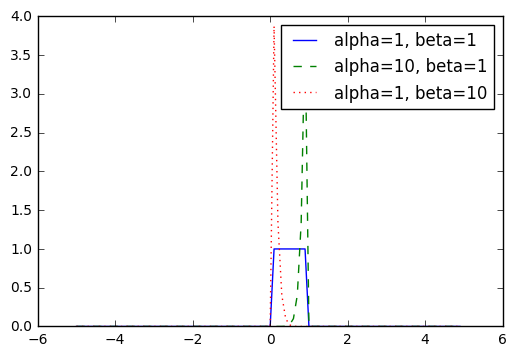

In [66]:
plt.plot(xs, [beta_pdf(x, alpha=1, beta=1) for x in xs], '-', label='alpha=1, beta=1')
plt.plot(xs, [beta_pdf(x, alpha=10, beta=1) for x in xs], '--', label='alpha=10, beta=1')
plt.plot(xs, [beta_pdf(x, alpha=1, beta=10) for x in xs], ':', label='alpha=1, beta=10')
plt.legend()
plt.show()

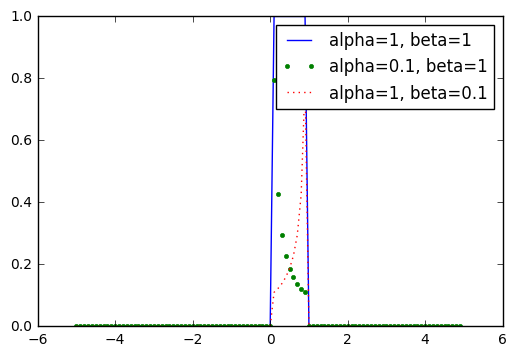

In [68]:
plt.plot(xs, [beta_pdf(x, alpha=1, beta=1) for x in xs], '-', label='alpha=1, beta=1')
plt.plot(xs, [beta_pdf(x, alpha=0.1, beta=1) for x in xs], '.', label='alpha=0.1, beta=1')
plt.plot(xs, [beta_pdf(x, alpha=1, beta=0.1) for x in xs], ':', label='alpha=1, beta=0.1')
plt.legend()
plt.show()

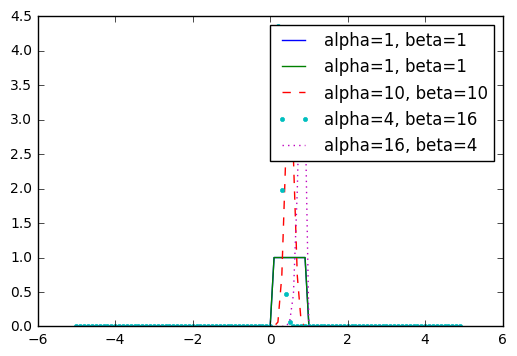

In [70]:
plt.plot(xs, [beta_pdf(x, alpha=1, beta=1) for x in xs], '-', label='alpha=1, beta=1')
plt.plot(xs, [beta_pdf(x, alpha=10, beta=10) for x in xs], '--', label='alpha=10, beta=10')
plt.plot(xs, [beta_pdf(x, alpha=4, beta=16) for x in xs], '.', label='alpha=4, beta=16')
plt.plot(xs, [beta_pdf(x, alpha=16, beta=4) for x in xs], ':', label='alpha=16, beta=4')
plt.legend()
plt.show()